
<h1>Прогнозирование оттока клиентов в телекоммуникационной компании</h1>

***Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.***

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.


**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- contract.csv — информация о договоре;
- personal.csv — персональные данные клиента;
- internet.csv — информация об интернет-услугах;
- phone.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.




**ПЛАН РАБОТЫ:**

- [***1. Подготовка:***](#1)
    
    - Загрузка необходимых библиотек
    
    - Подготовка необходимых функций
    
    - Загрузка данных

- [***2. Первичный анализ и предобработка данных:***](#2)

    - Вывод и изучение общей информации по каждой таблице
    
    - Проверка наличия дубликатов и пропусков
    
    - Изучение уникальных значений признаков
    
    - Объединение таблиц
    
    - Изменение типов данных

- [***3. Исследовательский анализ данных:***](#3)

    - Построение графиков
    
    - Исследование временных признаков
    
    - Исследование распределения категориальных признаков
    
    - Исследование числовых признаков
    
    - Исследование балланса целевого признака

- [***4. Подготовка к обучению моделей:***](#4)

    - Удаление ненужных признаков
    
    - Разделение данных на признаки и целевой признак
    
    - Разделенние данных на обучающе-валидационную выборку и тестовую с учетом возможного дисбаланса целевого признака
    
    - Кодирование категориальных признаков
    
    - Масштабирование числовых признаков
    
    - Подготовка функций для обучения модели с подбором оптимальных гиперпараметров и выводом результата включая график ROC-кривой
    
- [***5. Обучение моделей:***](#5)

    - Выбор моделей
    
    - Обучение моделей с подбором оптимальных гиперпараметров
    
    - Вывод по результатам кросс-валидации

- [***6. Тестирование моделей:***](#6)

    - Тестирование моделей
    
    - Проверка моделей на адекватность
    
    - Краткий вывод по результатам тестирования
    
- [***7. Отчет по выполненной работе***](#7)

## 1. Подготовка
<a id="1"></a>

In [1]:
import pandas as pd
import numpy as np
import re
from scipy import stats as st

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
# !pip install shap
import shap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

viewing_jpg = True
if viewing_jpg:
    import plotly.io as pio
    jpg_renderer = pio.renderers['jpg']
    pio.renderers.default='jpg'
    jpg_renderer.width = 950
    jpg_renderer.height = 550

import timeit

pd.options.mode.chained_assignment = None
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

RA_ST = 99

In [2]:
# Загрузка датасетов
def my_read(name):                                                                                 
    try:
        return pd.read_csv('/datasets/final_provider/' + name)
    except:
        return pd.read_csv(r'C:\Users\Admiral\Desktop\учеба\практикум\Проекты\Datasets\final_provider\\' + name)


# Первичный анализ
def initial_inspection(df, name):
    print('\033[1m' + '\033[94m' + '='*35 + f'[.....{name}.....]' + '='*35 + '\033[0m' + '\n')
    print('\n' + '\033[1m' + 'Общая информация' + '\033[0m' + '\n')
    df.info()
    print('\n', '\033[1m' + 'Случайные 10 объектов' + '\033[0m')
    display(df.sample(10, random_state = RA_ST))
    print('\n', '\033[1m' + 'Уникальные значения признаков' + '\033[0m')
    my_unique = []
    ind = []
    for i in range(df.shape[1]):
        uniq = list(df.iloc[:, i].unique())
        if len(uniq) < 50:
            my_unique.append([uniq])
            ind.append(i)
    display(pd.DataFrame(data=my_unique, index=df.columns[ind].values, columns=['unique_values']))
    print('\n', f'Количество дубликатов по коду клиента: {df["customerID"].duplicated().sum()}', '\n'*2)

Загрузим данные

In [3]:
contract = my_read('contract.csv')
personal = my_read('personal.csv')
internet = my_read('internet.csv')
phone = my_read('phone.csv')

## 2. Первичный анализ и предобработка данных
<a id="2"></a>

Выведем основную информацию по каждой таблице

In [4]:
initial_inspection(contract, 'Информация о договоре')
initial_inspection(personal, 'Персональные данные клиента')
initial_inspection(internet, 'Информация об интернет-услугах')
initial_inspection(phone, 'Информация об услугах телефонии')

===================================[.....Информация о договоре.....]===================================


Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

 Случайные 10 объектов


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2905,4692-NNQRU,2018-05-01,No,One year,No,Electronic check,79.20,1742.45
6651,2038-YSEZE,2017-09-01,No,Month-to-month,No,Mailed check,67.45,1801.1
5321,7718-UPSKJ,2014-05-01,No,One year,Yes,Credit card (automatic),106.40,7251.9
4293,2114-MGINA,2018-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,89.80,1129.1
5686,4369-HTUIF,2019-07-01,2020-01-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),85.15,503.6
2665,8166-ORCHU,2017-05-01,No,One year,Yes,Electronic check,93.55,3055.5
457,0942-KOWSM,2017-08-01,No,Two year,No,Bank transfer (automatic),80.80,2369.3
1106,4159-NAAIX,2014-11-01,No,Two year,No,Bank transfer (automatic),97.45,6253
4945,1223-UNPKS,2018-06-01,No,Two year,No,Mailed check,20.05,400
7037,2569-WGERO,2014-02-01,No,Two year,Yes,Bank transfer (automatic),21.15,1419.4



 Уникальные значения признаков


,unique_values
EndDate,"[No, 2019-12-01 00:00:00, 2019-11-01 00:00:00, 2019-10-01 00:00:00, 2020-01-01 00:00:00]"
Type,"[Month-to-month, One year, Two year]"
PaperlessBilling,"[Yes, No]"
PaymentMethod,"[Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)]"



 Количество дубликатов по коду клиента: 0 


===================================[.....Персональные данные клиента.....]===================================


Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

 Случайные 10 объектов


,customerID,gender,SeniorCitizen,Partner,Dependents
2905,4692-NNQRU,Female,0,Yes,No
6651,2038-YSEZE,Female,0,No,No
5321,7718-UPSKJ,Female,0,Yes,No
4293,2114-MGINA,Female,0,No,No
5686,4369-HTUIF,Male,1,No,No
2665,8166-ORCHU,Male,1,Yes,No
457,0942-KOWSM,Female,0,Yes,Yes
1106,4159-NAAIX,Female,0,No,No
4945,1223-UNPKS,Male,0,Yes,Yes
7037,2569-WGERO,Female,0,No,No



 Уникальные значения признаков


,unique_values
gender,"[Female, Male]"
SeniorCitizen,"[0, 1]"
Partner,"[Yes, No]"
Dependents,"[No, Yes]"



 Количество дубликатов по коду клиента: 0 


===================================[.....Информация об интернет-услугах.....]===================================


Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

 Случайные 10 объектов


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3335,5445-PZWGX,Fiber optic,Yes,Yes,No,Yes,No,Yes
4471,9840-DVNDC,Fiber optic,No,No,No,No,Yes,No
4118,6682-QJDGB,DSL,Yes,Yes,No,No,No,No
4733,6013-BHCAW,DSL,No,No,Yes,Yes,Yes,Yes
3590,1834-ABKHQ,DSL,No,No,Yes,No,No,No
2531,0461-CVKMU,Fiber optic,No,Yes,Yes,Yes,No,No
2819,3038-PQIUY,DSL,Yes,Yes,Yes,No,No,No
2160,4139-SUGLD,DSL,Yes,No,No,Yes,No,No
2438,4822-NGOCH,Fiber optic,No,Yes,Yes,No,No,No
3624,5701-ZIKJE,DSL,No,No,No,Yes,No,No



 Уникальные значения признаков


,unique_values
InternetService,"[DSL, Fiber optic]"
OnlineSecurity,"[No, Yes]"
OnlineBackup,"[Yes, No]"
DeviceProtection,"[No, Yes]"
TechSupport,"[No, Yes]"
StreamingTV,"[No, Yes]"
StreamingMovies,"[No, Yes]"



 Количество дубликатов по коду клиента: 0 


===================================[.....Информация об услугах телефонии.....]===================================


Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

 Случайные 10 объектов


,customerID,MultipleLines
3851,5161-UBZXI,No
4400,5134-IKDAY,No
1407,7114-AEOZE,No
5723,1577-HKTFG,No
2718,4674-HGNUA,Yes
4630,1328-EUZHC,No
764,1038-ZAGBI,No
5614,2868-LLSKM,Yes
110,6497-TILVL,No
561,4851-BQDNX,No



 Уникальные значения признаков


,unique_values
MultipleLines,"[No, Yes]"



 Количество дубликатов по коду клиента: 0 




По результататам первичного анализа данных сделаем выводы:
- **Таблица "contract"**:
    - В данной таблице содержится информация о договорах с 7043 клиентами и 8 признаками по каждому из них.
    - Пропуски и дубликаты отсутствуют.
    - Наименования столбцов некорректы, необходимо привести их к нижнему регистру и разделить слова нижним подчеркиванием для удобства.
    - Признаки:
        - customerID - 7043 уникальных кода клиентов. Как признак для обучения моделей данный столбец не несет полезной информации, но для слияния таблиц он нужен. Необходимо перевести его в статус индексов таблицы (так же и для остальных таблиц).
        - BeginDate - дата заключения договора. Необходимо перевести тип данных в DateTime и провести анализ периода заключения договоров.
        - Type - варианты оплаты услуг. Имеется три варианта - без ограничения (или ежемесячная оплата), заключение договора на один год и на два года.
        - PaperlessBilling - тип расчета. Если No то расчет наличный, Yes - безналичный.
        - PaymentMethod - способ безналичного расчета. На выбор имеется 4 варианта - по электронному чеку, по бумажному чеку высланному по почте, автоматическим банковским переводом или автоматическое снятие с кредитной карты.
        - MonthlyCharges - сумма ежемесячного платежа (вероятно евро или доллар). Тип данных подходящий.
        - TotalCharges - общая внесенная сумма за весь период пользования услугами. Тип данных object, необходимо изменить на float.
    - Целевой признак:
         - EndDate - дата расторжения договора. Возможно стоит вынести в отдельный признак дату расторжения, а непосредственно в целевом признаке заменить дату на "Yes". Что примечательно, за весь имеющийся у нас по данным период, клиенты отключались только в 4 определенных дня - 1 октября 2019, 1 ноября 2019, 1 декабря 2019 и 1 января 2020, хотя по стобцу BeginDate можно заметить, что дата подключения может начинаться аж с 2014 года.
    - Часть категориальных признаков имеет всего два варианта, то есть являются булевыми признаками. Стоит заменить их на значения 1 и 0. Остальные категориальные признаки имеют немногим большее количество унакальных значений. Вероятно стоит перед обучением моделей закодировать их методом One-Hot Encoding.
- **Таблица "personal"**:
    - В данной таблице содержатся персональные данные о тех же 7043 клиентах (стоит проверить схожесть customerID с остальными таблицами) и 5 признаками по каждому из них.
    - Пропуски и дубликаты отсутствуют.
    - Наименования столбцов некорректы, необходимо привести их к нижнему регистру и разделить слова нижним подчеркиванием для удобства.
    - Признаки:
        - customerID - 7043 уникальных кода клиентов. Необходимо перевести его в статус индексов таблицы.
        - gender - имеет две категории пола - Female и Male. Вероятно стоит изменить наименование признака например на Female, а его значения на 1 и 0.
        - SeniorCitizen - признак с указанием, является ли клиент пенсионером.
        - Partner - наличие супруга или супруги.
        - Dependents - наличие иждевенцев.
- **Таблица "internet"**:
    - В данной таблице содержится информация о тех клиентах, которым предоставляется услуга подключения интернета. Таких клиентов 5517, что говорит о том, что только 78% клиентов компании подключили данную услугу. Каждый объект в таблице имеет 8 признаков.
    - Пропуски и дубликаты отсутствуют.
    - Наименования столбцов некорректы, необходимо привести их к нижнему регистру и разделить слова нижним подчеркиванием для удобства.
    - Признаки:
        - customerID - 5517 уникальных кодов клиентов. Необходимо перевести его в статус индексов таблицы.
        - InternetService - два типа подключения интернета - через телефонную линию или оптоволоконный кабель.
        - OnlineSecurity - булевый признак - отметка о подключении клиентом дополнительной услуги по блокировке небезопасных сайтов.
        - OnlineBackup - булевый признак - отметка о подключении клиентом дополнительной услуги по выделению доступа к облачному хранилищу файлов для резервного копирования данных.
        - DeviceProtection - булевый признак - отметка о подключении клиентом дополнительной услуги по предоставлению антивируса.
        - TechSupport - булевый признак - отметка о подключении клиентом дополнительной услуги по предоставлению выделенной линии технической поддержки.
        - StreamingTV - булевый признак - отметка о подключении клиентом дополнительной услуги по предоставлению стримингового телевидения.
        - StreamingMovies - булевый признак - отметка о подключении клиентом дополнительной услуги по предоставлению доступа к каталогу фильмов.
    - Перед обучением моделей стоит перевести категориальный признак в булевый, а значения всех булевых признаков заменить на 1 и 0.
- **Таблица "phone"**:
    - В данной таблице содержится информация о тех клиентах, которым предоставляется услуга по подключению стационарной телефонной связи. Таких клиентов 6361, что говорит о том, что только 90% клиентов компании подключили данную услугу. Каждый объект в таблице имеет 2 признака.
    - Пропуски и дубликаты отсутствуют.
    - Наименования столбцов некорректы, необходимо привести их к нижнему регистру и разделить слова нижним подчеркиванием для удобства.
    - Признаки:
        - customerID - 6361 уникальных кодов клиентов. Необходимо перевести его в статус индексов таблицы.
        - MultipleLines - булевый признак - отметка о подключении клиентом дополнительной услуги по подключению телефонного аппарата к нескольким линиям одновременно. Перед обучением моделей необходимо значения признака изменить на 1 и 0.

Для каждой таблицы обозначим customer_id как индекс.

In [5]:
contract.set_index('customerID', inplace=True)
personal.set_index('customerID', inplace=True)
internet.set_index('customerID', inplace=True)
phone.set_index('customerID', inplace=True)

Объединим все таблицы в одну и выведем общую информацию

In [6]:
join_data = contract.join(personal, how='outer')\
                    .join(internet, how='outer')\
                    .join(phone, how='outer')
join_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

Приведем наименования столбцов к нижнему регистру и разделим слова нижним подчеркиванием

In [7]:
join_data.rename((lambda x: '_'.join(re.findall('[A-Z]*[a-z]*', x)).lower()[:-1]), axis='columns', inplace=True)
join_data.index.names = ['customer_id']
display(join_data.head(0))

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,


У нас появились пропуски из за того, что часть клиентов не подключали себе интернет и соответственно дополнительные услуги к нему, а другая часть не подключили телефонную связь. Заполним пропуски следующим образом: 
- Пропуски по дополнительным услугам заменим на "No".
- По телефонии выведем отдельный признак с двумя категориями: "Yes" если клиент подключал телефонную связь в любом виде и "No" если клиент совсем не подключал данную услугу. Сам признак "multiple_lines" уже будет обозначать дополнительную услугу по подключению  телефонного аппарата к нескольким линиям одновременно.
- С признаком "internet_service" поступим иначе. Выведем из него новый признак как доп услугу с двумя категориями: "Yes" если клиет выбрал тип интернета Fiber optic и "No" если не выбрал этот тип. Сам признак "internet_service" изменим, заменив все пропуски на "No", а остальные значения на "Yes". Он будет обозначать факт подключения клиента к сети интернет.

Начнем в обратном порядке.

In [8]:
join_data['fiber_optic'] = join_data['internet_service'].apply(lambda x: 'Yes' if x == 'Fiber optic' else 'No')

join_data['internet_service'] = join_data['internet_service'].apply(lambda x: 'Yes' if x in  ['Fiber optic', 'DSL'] else 'No')

join_data['telephony_service'] = join_data['multiple_lines'].apply(lambda x: 'Yes' if x in  ['Yes', 'No'] else 'No')

join_data.fillna('No', inplace=True)

Изменим тип данных столбца begin_date на DateTime

In [9]:
join_data['begin_date'] = join_data['begin_date'].astype('datetime64[ns]')

Выведем целевой признак в отдельный столбец

In [10]:
join_data['disconnected'] = join_data['end_date'].apply(lambda x: 0 if x == 'No' else 1).astype('uint8')

## 3. Исследовательский анализ данных
<a id="3"></a>

Изучим времянной промежуток нашей выборки и ежемесячный приток новых клиентов

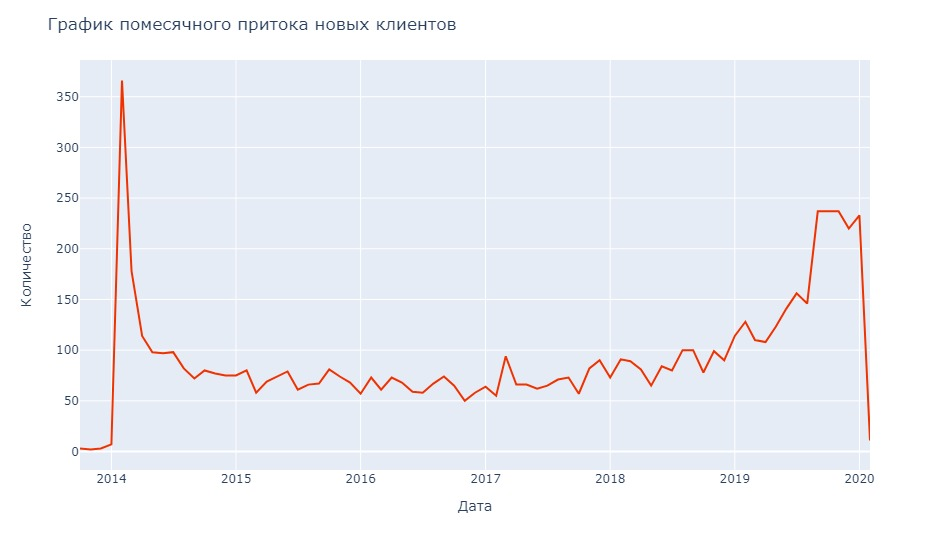

In [11]:
monthly_influx_customers = join_data['begin_date'].value_counts()\
                                                  .reset_index()\
                                                  .sort_values(by='index')\
                                                  .rename(columns={'index':'date', 'begin_date':'count'})
fig = px.line(monthly_influx_customers, x='date', y='count', height=400, color_discrete_map = {'': 'rgb(240,50,0)'})
fig.update_layout(hovermode='x unified', xaxis_tickformat='%Y', xaxis_hoverformat='%b,%Y',\
                  title='График помесячного притока новых клиентов',\
                  xaxis_title='Дата',  yaxis_title='Количество')
fig.show()

Наша выгрузка содержит данные о клиентах включительно с октября 2014 года по февраль 2020. Видно что в первые 4 месяца клинтов почти не прибывало, видимо это период формирования компании. Далее в феврале 2014 видно резкое увеличение клиентов, при этом оно самое большое за весь период имеющихся у нас данных - 366 клиентов за месяц. Далее ежемесячный приток пошел на спад и до января 2019 года не превышал 100 человек в месяц. Начиная с января 2019 года этот показатель стал постепенно увеличиваться до 150, а в сентябре резко поднялся до 237 и продолжал держаться на этой отметке. Датой выгрузки является 1 февраля 2020, видимо поэтому в этом месяце прирост составил всего 11 человек.

Колонка total_charges имеет неподходящий тип данных, возможно в ней содержатся нечисловые значения. Проверим это

In [12]:
total_charges_nan = join_data[pd.to_numeric(join_data['total_charges'], errors='coerce').isna()]
display(total_charges_nan)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,fiber_optic,telephony_service,disconnected
customer_id,,,,,,,,,,,,,,,,,,,,,,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,No,0
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,No,No,No,No,No,No,No,No,Yes,0
2775-SEFEE,2020-02-01,No,Two year,Yes,Bank transfer (automatic),61.90,,Male,0,No,Yes,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,0
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,No,Yes,0
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,No,No,No,No,No,No,No,No,Yes,0
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes,No,Yes,0
4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,0
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes,No,Yes,0
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,No,No,0


Все 11 последних новых клиентов имеют пропуск в столбце по общей сумме платежей, вероятно платеж не успел пройти в момент выгрузки данных. Проверим равенство месячного платежа и общей суммы новых клиентов за предыдущий месяц.

In [13]:
display(len(join_data.query('begin_date == "2020-01-01"')[['monthly_charges', 'total_charges']]\
                     .astype('float64')\
                     .query('monthly_charges != total_charges')))

0

Есть два варианта заполнения пропусков:
- Удалить такие строки, так как есть подозрение что не все клиенты в итоге оплатили и подключили услуги
- Заполнить пропуски данными с колонки monthly_charges, так как они будут равны после прохождения платежа

Выбираю второй выриант.

In [14]:
join_data.loc[(total_charges_nan.index), 'total_charges'] = join_data['monthly_charges']
join_data['total_charges'] = join_data['total_charges'].astype('float64')

Изучим графики распределения клиентов по категориальным признакам с разделением на активных и отключенных клиентов

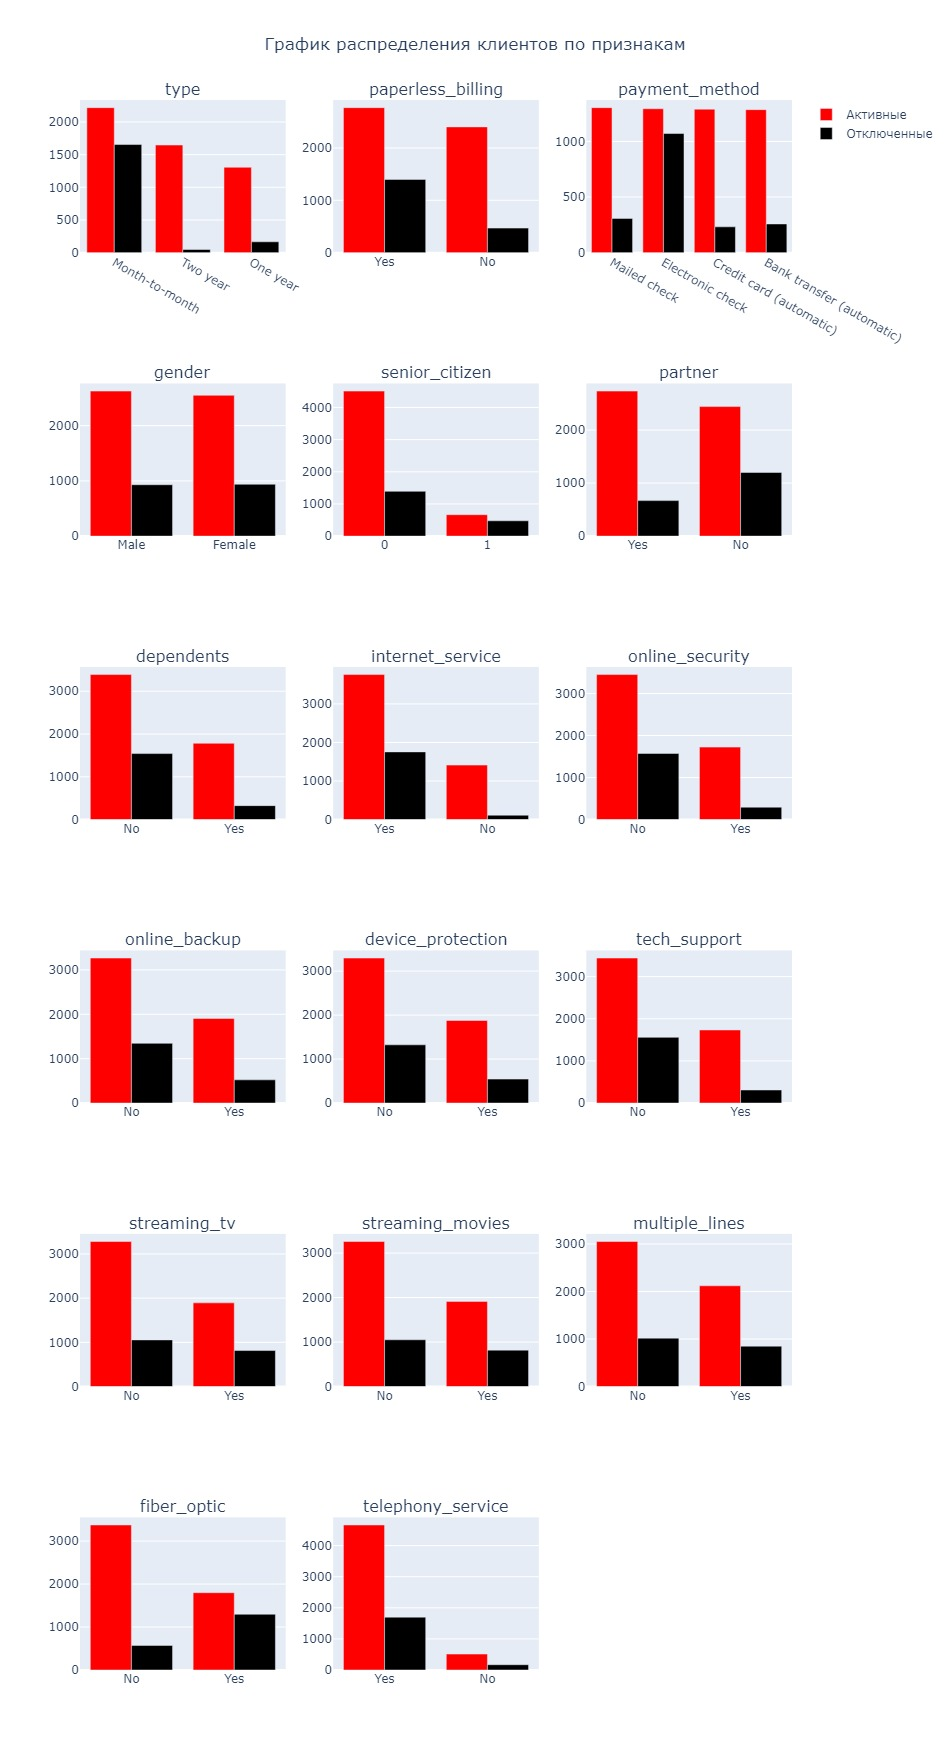

In [15]:
if viewing_jpg:
    jpg_renderer.width = 950
    jpg_renderer.height = 1750

df_category = join_data.iloc[:, [2,3,4,7,8,9,10,11,12,13,14,15,16,17,18,19,20, -1]]

fig = make_subplots(rows=6, cols=3, subplot_titles=df_category.columns[:-1])
row, col = 1, 1
showlegend = True
for i in range(17):
    dis = df_category.query('disconnected == 0').iloc[:, i].value_counts()
    con = df_category.query('disconnected == 1').iloc[:, i].value_counts()
    fig.add_trace(go.Bar(y=dis.values, x=dis.index, marker=dict(color='red'),\
                         showlegend=showlegend, name='Активные'), row, col)
    fig.add_trace(go.Bar(y=con.values, x=con.index, marker=dict(color='black'),\
                         showlegend=showlegend, name='Отключенные'), row, col)
    showlegend = False
    if col == 3:
        col = 1
        row += 1
    else:
        col += 1

fig.update_layout(title='График распределения клиентов по признакам', title_x = 0.5, height=1750, width=900)
fig.show()

По графикам можно сделать следующие предположения:
- Признак type - у активных клиентов менее популярным является заключение договора на один год (1307 клиентов), немногим чаще выбирают договора сроком на 2 года (1647 клиентов). Наиболее популярным сроком заключения договоров является один месяц (2220 клиентов). В отношении отключенных клиентов ситуация иная - подавляющее число выбирает договора сроком на один месяц (1655 на месяц против 214 на год или два). Вероятно нужно прикладывать усилия в сторону удержания таких клиентов и заключения с ними договоров на более длительный срок.
- Признак paperless_billing - как активные клиенты так и отключенные чаще выбирают безналичный тип оплаты, но в случае с отключенными такое различие более ярко выражено, а именно в 3 раза.
- Признак payment_method - активные клиенты с одинаковой вероятностью выберут один из способов безналичного расчета, но отключенные в разы чаще выбирают оплату по электронному чеку.
- Признак gender - по половому признаку распределение для активных и отключенных клиентов выглядит одинаково.
- Признак senior_citizen - вероятность отключения клиента в пенсионном возрасте гораздо выше чем в противоположном случае (42% против 24%)
- Признак partner - наличие супруга(и) играет важную роль в определении возможного отключения клиента. Доли у активных клиентов, имеющих супруга(у) и неимеющих, примерно одинаковы, тогда как среди отключенных клиентов в 1.8 раз чаще встречаются незамужние и холостые.
- Признак dependents - можно отметить, что вероятность отключения клиента, имеющего иждевенцев, гораздо ниже, чем у кдиента не имеющего иждевенцев.
- Признаки internet_service и fiber_optic - вероятность ухода клиента гораздо выше, если он все же подключил себе интернет. Более того, чаще отключаются клиенты выбравшие оптоволоконное подключение. Возможно их неустраивало качество интернета по оптоволокну или его стоимость?
- Признаки online_security, online_backup, device_protection и tech_support - по этим дополнительным услугам можно отметить, что активные клиенты чаще их подключают, то есть клиент не подключивший одну из этих услуг имеет большую вероятность ухода.
- Признаки streaming_tv и streaming_movies - тут стоит отметить что активные клиенты чаще не пользуются услугами по телевидению и доступу к каталогу фильмов, тогда как отключенные клиенты распределены примерно в равных долях по наличию у них этих услуг. Возможно существуют какие либо проблемы с этими сервисами, если их редко выбирают и часто уходят из компании при их выборе?
- Признаки telefone_service и multiple_lines - что касается подключения телефонной связи в любом виде, тут отсутствует явное различие между отключенными и активными клиентами.
- В общем можно отметить что клиенты в основном чаще отказываются от дополнительных услуг.

Изучим основные статистические показатели по числовым признакам

In [16]:
display(join_data[['monthly_charges', 'total_charges']].describe().T)

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2279.798992,2266.730170,18.80,398.55,1394.55,3786.60,8684.80


Нулевые и отрицательные значения отсутствуют, это хорошо. По общим платежам можно отметить большой разбег между максимальным и минимальным значениями, что неудивительно, все клиенты начали пользоваться услугами компании в разное время, а значит у новых клиентов сумма будет меньше.

Построим гистограмму распределения вероятностей стоимости ежемесячного платежа для активных клиентов и отключенных.

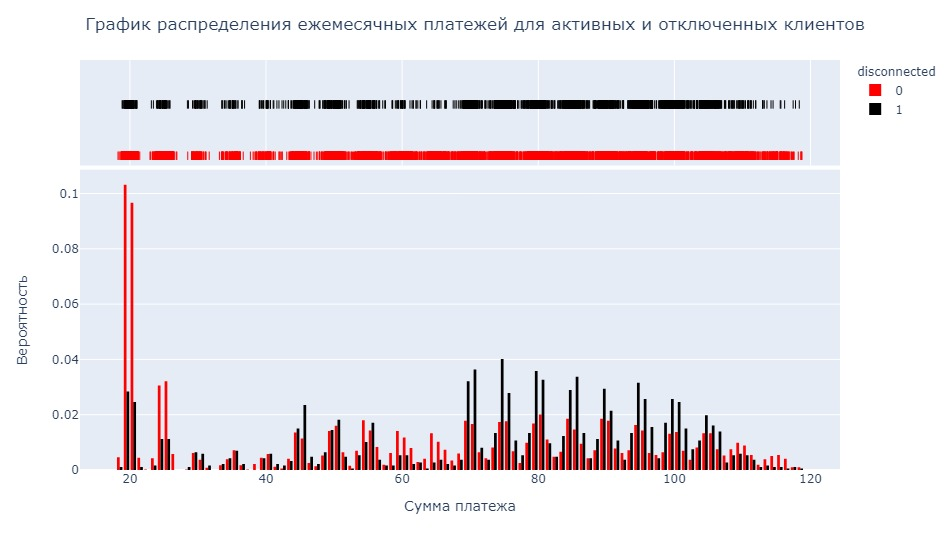

In [17]:
if viewing_jpg:
    jpg_renderer.width = 950
    jpg_renderer.height = 550

def my_hist(df, x, histnorm, xtitl, ytitl, title, nbins):
    fig = px.histogram(df, x=x, color='disconnected', hover_data=join_data.iloc[:, :2],\
                       marginal='rug', color_discrete_sequence=['red', 'black'], histnorm=histnorm, nbins=nbins)
    fig.update_layout(barmode='group', title=title, xaxis_title=xtitl,  yaxis_title=ytitl, title_x = .5)
    fig.show()
    
my_hist(join_data, 'monthly_charges', 'probability density', 'Сумма платежа', 'Вероятность',\
        'График распределения ежемесячных платежей для активных и отключенных клиентов', 150)

Можно выделить три основных пакета(как ты отметил с разделением на бедных, богатых, ну и обычных) услуг(условно) с различными наборами:
- light - от 18 до 27.5 евро
- standart - от 27.5 до 67.5 евро
- advanced - от 67.5 до 119 евро

С другой стороны можно эти пакеты разделить на более мелкие (то есть по количеству услуг), которые хорошо видны на графике. Их всего получится 20 основных вариаций со средними значениями начиная с 20 евро с шагом в 5 евро и заканчивая 115 евро.

На графике видно, что активные клиенты с большей вероятностью выбирают наборы услуг низкой стоимостью до 26 евро, чем отключенные клиенты. Отключенные клиенты в основном выбирают наборы услуг стоимостью выше 68 евро. Должна быть причина, почему на более дорогих тарифах существует большая вероятность отключения. Возможно клиентов не устраивает соотношение цены-качества  или просто качество предоставляемых им услуг?

Построим гистограмму распределения вероятностей общей суммы платежей для активных клиентов и отключенных.

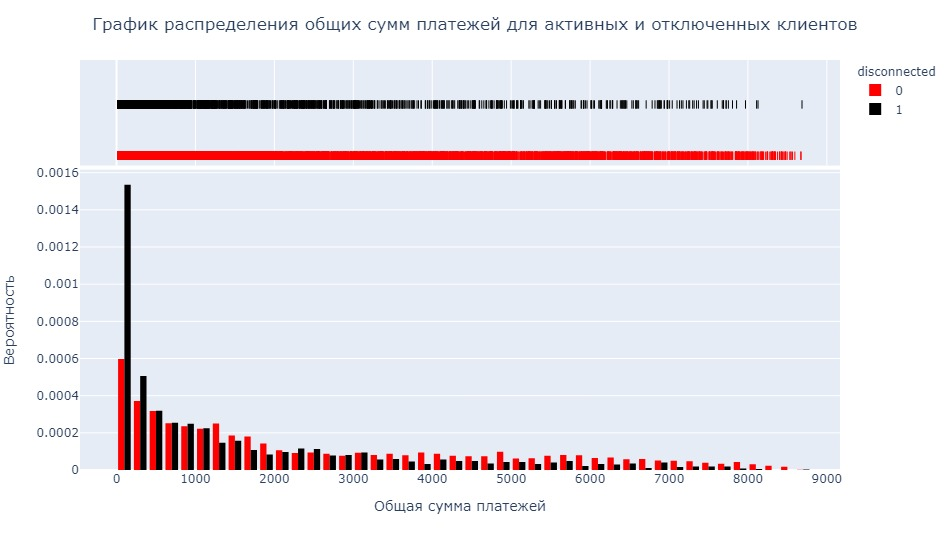

In [18]:
my_hist(join_data, 'total_charges', 'probability density', 'Общая сумма платежей', 'Вероятность',\
        'График распределения общих сумм платежей для активных и отключенных клиентов', None)

Хоть и основная часть отключенных клиентов и была сосредоточена в районе высоких ежемесячных платежей, на данном графике видно, что такие клиенты в итоге платят в основном немного, а значит недолго задерживаются в качестве клиента компании.

Изучим статистические показатли ежемесячных платежей для отключенных и активных клиентов

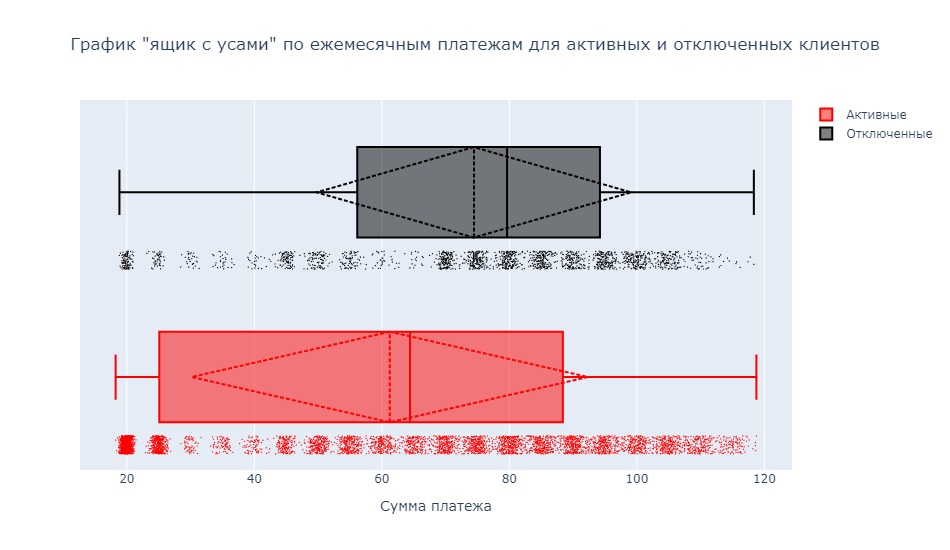

In [19]:
fig = go.Figure()
fig.add_trace(go.Box(x=join_data.query('disconnected == 0')['monthly_charges'],\
                     marker_color='red', name='Активные', boxmean='sd',\
                     boxpoints='all', jitter=.2, marker_size=1.3))
fig.add_trace(go.Box(x=join_data.query('disconnected == 1')['monthly_charges'],\
                     marker_color='black', name='Отключенные', boxmean='sd',\
                     boxpoints='all', jitter=.2, marker_size=1.3))
fig.update_layout(yaxis=dict(showticklabels=False),\
                  title='График "ящик с усами" по ежемесячным платежам для активных и отключенных клиентов',\
                  title_x = 0.5, xaxis_title='Сумма платежа')
fig.show()

По графику можно сделать следующие выводы:
- Минимальные и максимальные значения для обоих групп клиентов в выборке равны
- Медиана и среднее значения ежемесячных платежей у активных клиентов ниже, чем у отключенных
- Стандартное отклонение и межквартильный размах у отключенных клиентов заметнее меньше, чем у активных

Изучим баланс целевого признака в процентном соотношении

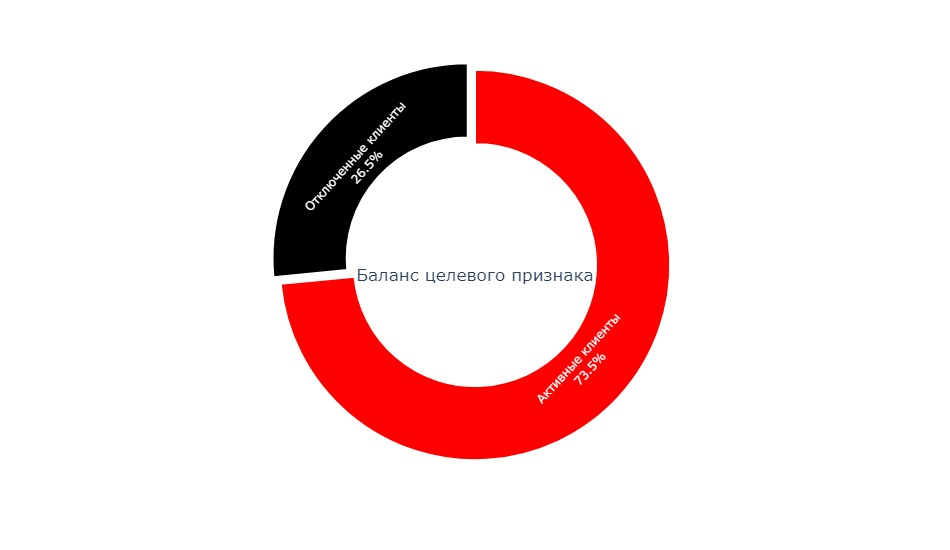

In [20]:
fig = px.pie(join_data['disconnected'].value_counts(), values='disconnected',\
             names=['Активные клиенты', 'Отключенные клиенты'])

fig.update_layout(height=600, showlegend=False, title_text='Баланс целевого признака', title_x = .5, title_y=.5)

fig.update_traces(pull=[0.0, 0.05], hole=.62, textposition='inside', textinfo='percent+label',\
                  marker=dict(colors=['red', 'black'], line=dict(color='white', width=2)))
fig.show()

Наблюдаем сильный дисбаланс в сторону отрицательного класса. Это нужно учесть при построении модели.

Выведем новый признак, обозначающий количество дней со дня заключения договора до момента выгрузки данных, или до даты расторжения договора для отключенных клиентов.

In [21]:
join_data['end_date'].replace('No', '2020-02-01 00:00:00', inplace=True)
join_data['end_date'] = join_data['end_date'].astype('datetime64[ns]')
join_data['period_in_days'] = (join_data['end_date']-join_data['begin_date']).dt.days.astype('uint16')

Изучим распределение периода пользования услугами для активных клиентов и отключенных

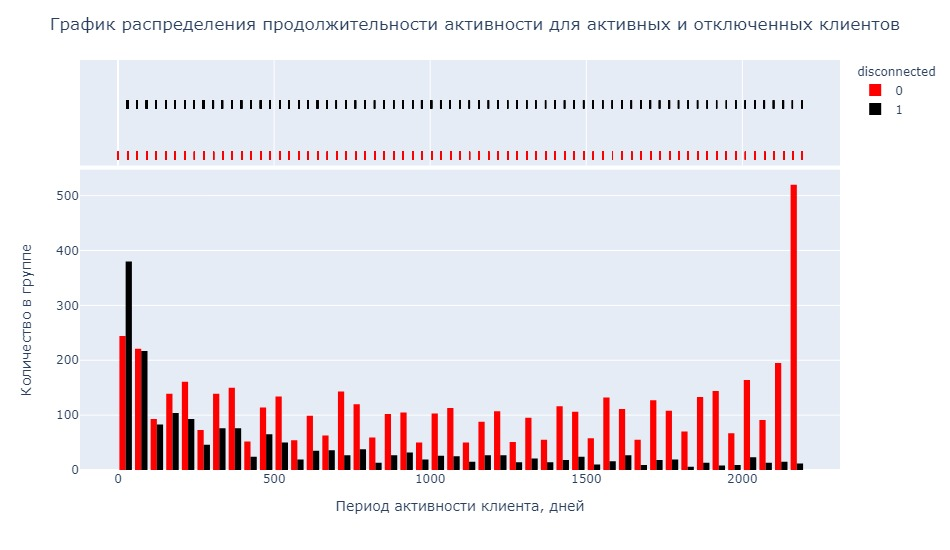

In [22]:
my_hist(join_data, 'period_in_days', None, 'Период активности клиента, дней', 'Количество в группе',\
        'График распределения продолжительности активности для активных и отключенных клиентов', None)

По графику видно, у активных клиентов распределение близко к равномерному и только на максимальных и минимальных значениях видно увеличение. Можно отметить, что вследствии определенных успешных действий компании в первые сто дней и последнии 50 дней по выборке, было привлечено больше клиентов, чем обычно.

По отключенным клиентам ситуация иная. Они как правило не задерживаются надолго, и пользуются услугами в основном не более года, а в основном до трех месяцев. Но также имеются в небольшом количестве клиенты, которые пользовались услугами от одного года до 5 лет.

Выведем тепловую карту корреляции между количественными признаками

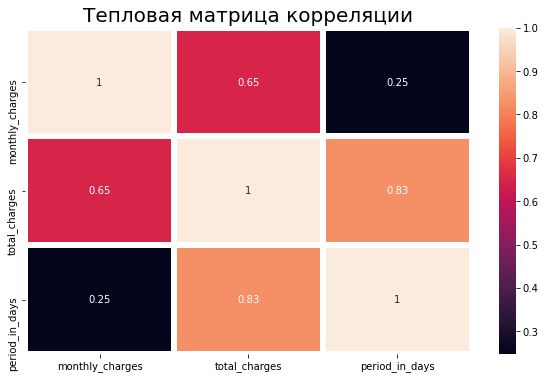

In [23]:
plt.figure(figsize=(10, 6))
sns.heatmap(join_data[['monthly_charges', 'total_charges', 'period_in_days']].corr(),\
            annot = True, linewidths=5)
plt.title('Тепловая матрица корреляции', fontsize=20)
plt.show()

- Наблюдаем среднюю пложительную корреляцию между ежемесячными платежами и общими платежами за все время.
- Имеется сильная корреляция между общими платежами и периодом активности клиента. После изучения важности признаков перед построением моделей, необходимо избавится от одного из коррелирующих между собой признаков.

## 4. Подготовка к обучению моделей
<a id="4"></a>

Узнаем, какие признаки действительно важны для обучения моделей. Для начала подготовим сами признаки. Начнем с удаления столбцов с датой заключения и расторжения договоров.

In [24]:
join_data.drop(['begin_date', 'end_date'], axis=1, inplace=True)

Разделим данные на признаки и целевой признак

In [25]:
X = join_data.drop(['disconnected'], axis=1)
y = join_data['disconnected']

Сохраним в разные списки перечни категориальных и непрерывных признаков

In [26]:
numerical_features = ['monthly_charges', 'total_charges', 'period_in_days']
categorical_features = X.drop(numerical_features, axis=1).columns

Закодируем категориальные признаки

In [27]:
X_dumm = pd.get_dummies(X, columns=categorical_features, prefix=categorical_features, drop_first=True)

Разделим данные на обучающую, валидационую и тестовую выборки

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_dumm, y, test_size=.2, random_state=RA_ST, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, random_state=RA_ST, stratify=y_train)

Масштабируем численные признаки

In [29]:
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_valid[numerical_features] = scaler.transform(X_valid[numerical_features])

Обучим на всех признаках логистическую регрессию и выведем значения AUC-ROC и accuracy

In [30]:
def checking_metrics(X_tr, X_v, y_tr, y_v, model):
    model = model.fit(X_tr, y_tr)
    print(f'ROC-AUC: {round(roc_auc_score(y_v, model.predict_proba(X_v)[:,1]), 4)}')
    print(f'Accuracy: {round(accuracy_score(y_v, model.predict(X_v)), 4)}')
    return model


log_reg = checking_metrics(X_train, X_valid, y_train, y_valid, LogisticRegression(random_state=RA_ST))

ROC-AUC: 0.8477
Accuracy: 0.8154


Выведем график с показателями важности признаков для алгоритма логической регрессии

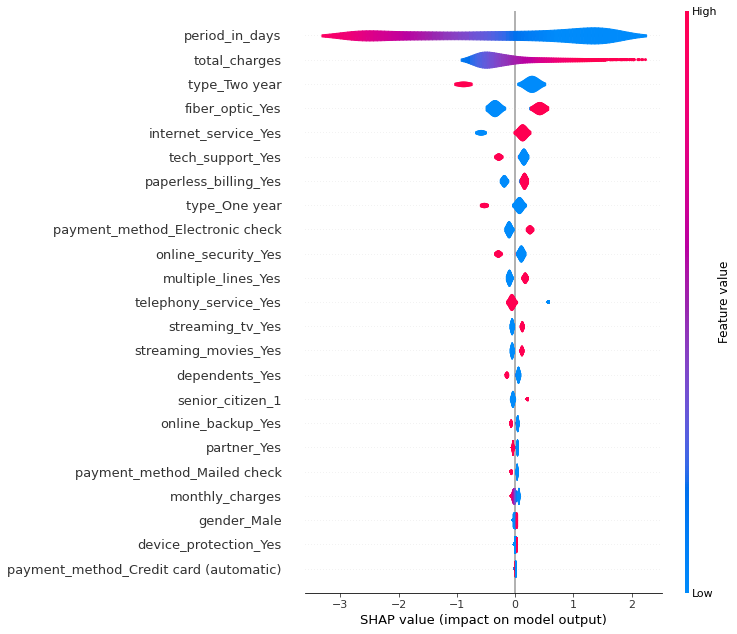

In [31]:
explainer = shap.LinearExplainer(log_reg, X_train, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid.values, feature_names=X_valid.columns, max_display=26, plot_type='violin')

По графику можно сделать следующие выводы:
- Наиболее сильное влияние на выбор класса целевого признака имеет признак с указанием количества месяцев активности клиента. Чем дольше клиент в компании, тем меньше шанс его ухода и наоборот.
- Тип подключения также имеет сильное влияние - клиенты с DSL менее подвержены риску ухода, тогда как клиенты с Fiber optic наоборот, имеют большую вероятность ухода.
- Чем больше клиент заплатил за услуги за весь период активности, тем выше шанс его ухода.
- Клиенты заключившие договор на один или два года чаще остаются в компании.
- Клиенты, которые не подключили себе интернет, с большей вероятностью не покинут компанию.
- Такие признаки как наличие пенсионного возраста, иждевенцев, супруга(и), антивируса и облачного кранилища, способ оплаты и метод оплаты, разделение по половому признаку, наличие стримингового телевидения или доступа к катологу фильмов, почти никак не влияют на предсказания модели.
- Остальные признаки имеют несильное, но значимое влияние.

Проделаем то же самое для модели Случайного леса

In [32]:
rand_forest = checking_metrics(X_train, X_valid, y_train, y_valid, RandomForestClassifier(random_state=RA_ST))

ROC-AUC: 0.8483
Accuracy: 0.8146


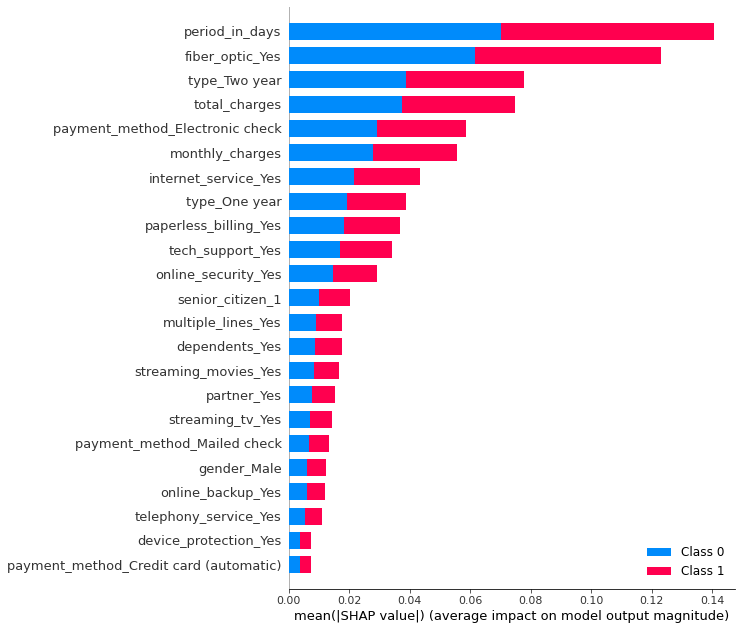

In [33]:
explainer = shap.TreeExplainer(rand_forest)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid.values, feature_names=X_valid.columns, max_display=23)

Для случайного леса все выглядит почти также, как для логической регрессии, только список незначимых признаков тут больше. К неважным добавились такие признаки как возможность подключения телефонного аппарата к нескольким линиям и подключение к телефонной сети. Кроме того для случайного леса наибольшее влияние имеет признак по типу интернет подключения  и ежемесячные платежи. Попробуем поочередно удалять один из признаков, и считать ROC-AUC для Логичесой регрессии и Случайного леса. Значения сохраним в соответствующие переменные.

In [34]:
log_reg_auc_drop = []
rand_forest_auc_drop = []
for i in X_train.columns:
    log_reg = LogisticRegression(random_state=RA_ST).fit(X_train.drop(i, axis=1), y_train)
    log_reg_auc_drop.append(roc_auc_score(y_valid, log_reg.predict_proba(X_valid.drop(i, axis=1))[:,1]))
    
    rand_forest = RandomForestClassifier(random_state=RA_ST).fit(X_train.drop(i, axis=1), y_train)
    rand_forest_auc_drop.append(roc_auc_score(y_valid, rand_forest.predict_proba(X_valid.drop(i, axis=1))[:,1]))

Построим график полученных значений ROC-AUC для каждого признака при его удалении

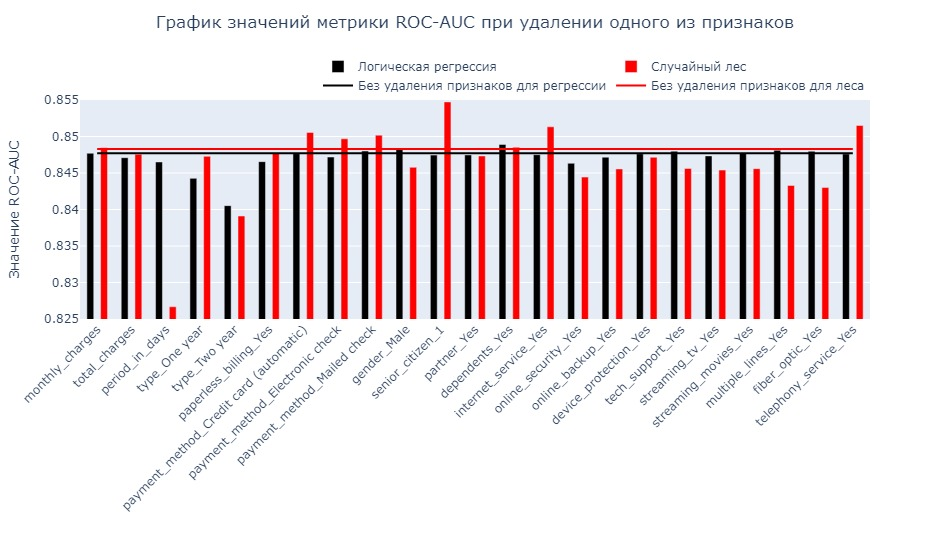

In [35]:
fig = go.Figure()
fig.add_trace(go.Bar(x=X_train.columns, y=log_reg_auc_drop, name='Логическая регрессия', marker_color='black', width=.2))
fig.add_trace(go.Bar(x=X_train.columns, y=rand_forest_auc_drop, name='Случайный лес', marker_color='red', width=.2))

fig.add_trace(go.Scatter(x=[X_train.columns[0], X_train.columns[-1]], y=[.8477, .8477],\
                         mode='lines', line_color='black', name='Без удаления признаков для регрессии'))
fig.add_trace(go.Scatter(x=[X_train.columns[0], X_train.columns[-1]], y=[.8483, .8483],\
                         mode='lines', line_color='red', name='Без удаления признаков для леса'))

fig.update_layout(barmode='group', xaxis_tickangle=-45, yaxis=dict(range=[.825, .855]), height=700,\
                  title='График значений метрики ROC-AUC при удалении одного из признаков', title_x =.5, title_y=.97,\
                  yaxis_title='Значение ROC-AUC',  xaxis_title='',\
                  legend=dict(orientation='h', yanchor='bottom', y=1, xanchor='right', x=1))
fig.show()

По графику можно сделать следующий вывод: 
- Для Логической регрессии и Случайного леса одновременно при удалении таких признаков как monthly_charges, total_charges, payment_method_Credit card (automatic), payment_method_Electronic check, payment_method_Mailed check, gender_Male, senior_citizen_1, partner_Yes, dependents_Yes, internet_service_Yes, device_protection_Yes и telephony_service_Yes, значение метрики ROC-AUC почти не меняется или в некоторых случаях даже увеличивается. Удалим из основного датасета с признаками все "мешающие" столбцы.

In [36]:
unimportant_features = ['monthly_charges', 'total_charges', 'payment_method',
                        'gender', 'senior_citizen', 'partner', 'dependents',\
                        'internet_service', 'device_protection', 'telephony_service']
X.drop(unimportant_features, axis=1, inplace=True)

Выведем общую информацию

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   type               7043 non-null   object
 1   paperless_billing  7043 non-null   object
 2   online_security    7043 non-null   object
 3   online_backup      7043 non-null   object
 4   tech_support       7043 non-null   object
 5   streaming_tv       7043 non-null   object
 6   streaming_movies   7043 non-null   object
 7   multiple_lines     7043 non-null   object
 8   fiber_optic        7043 non-null   object
 9   period_in_days     7043 non-null   uint16
dtypes: object(9), uint16(1)
memory usage: 884.0+ KB


Напишем функцию, которая при вызове заменит типы всех категориальных признаков на "category"

In [38]:
def conversion_to_the_type(df):
    for col in df.columns:
        if len(df[col].unique()) <= 20:
            df[col] = df[col].astype('category')
    return df

Разделим данные на обучающе-валидационную выборку и тестовую

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RA_ST, stratify=y)

Подготовим пустую таблицу в которую будем добавлять результаты кросс-валидации различных моделей (Был проведен подбор оптимальных гиперпараметров для моделей, но не включен в проект ввиду крайне длительного по времени данного процесса. Далее мы будем уже по подобраным гиперпараметрам обучать модели).

In [40]:
all_result = pd.DataFrame(columns=['Модель', 'Оптимальные параметры', 'ROC-AUC кросс-валидация',\
                                   'accuracy кросс-валидация','Время обучения, сек.',\
                                   'ROC-AUC тест', 'accuracy тест', 'precision тест',\
                                   'recall тест', 'Время предсказания, сек.'])

Объявим переменную, в которую будем добавлять обученные модели

In [41]:
best_models = []

Напишем функцию, которая в процессе кросс-валидации будет масштабировать непрерывные признаки и кодировать категориальные.

In [42]:
def preparation_features(pipe_classifier, X_tr):
    X_tr = conversion_to_the_type(X_tr)
    
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    numeric_features = X_tr.loc[:,X_tr.dtypes != 'category'].columns
    categorical_features = X_tr.loc[:,X_tr.dtypes == 'category'].columns
    
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),\
                                                   ('cat', categorical_transformer, categorical_features)])
    
    return Pipeline(steps=[('preprocessor', preprocessor), ('classifier', pipe_classifier)])

Напишем функцию, которая будет выводить график ROC-кривой

In [43]:
def plotly_roc_curve(y_tr, y_score):
    fpr, tpr, thresholds = roc_curve(y_tr, y_score[:, 1])

    fig = px.area(x=fpr, y=tpr, width=500, height=500, title='ROC Curve',\
                  labels=dict(x='False Positive Rate', y='True Positive Rate'))
    
    fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)

    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()

Напишем функцию, которая на вход получит необходимую модель, словарь с параметрами для подбора оптимальных, признаки для обучения и целевой признак к ним, а на выходе добавит в переменную best_models лучшую модель с оптимальными параметрами, выведет график ROC-кривой и необходимые показатели по результатам кросс-валидации.

In [44]:
def my_CV(pipe_classifier, X_tr, y_tr, results, classifier_param):
    ss_ohe = preparation_features(pipe_classifier, X_tr)
    CV = GridSearchCV(ss_ohe, classifier_param, cv = 5,\
                      n_jobs = -1, verbose = 0, pre_dispatch='2 * n_jobs',\
                      scoring = 'roc_auc')
    
    time_start_fit = timeit.default_timer()
    CV.fit(X_tr, y_tr)
    time_fit = timeit.default_timer() - time_start_fit
    
    auc_score = round(CV.best_score_, 4)
    acc_score = round(accuracy_score(y_tr, CV.best_estimator_.predict(X_tr)), 4)
    model_name = (str(CV.best_estimator_['classifier']).split('(')[0])
  
    result = pd.DataFrame(data=[[model_name, CV.best_params_, auc_score, acc_score,\
                                 round(time_fit, 2), None, None, None, None, None]],\
                          columns=results.columns)
    
    display(result)
    y_score = CV.best_estimator_.predict_proba(X_tr)
    plotly_roc_curve(y_tr, y_score)
    
    best_models.append(CV.best_estimator_)
    return results.append(result, ignore_index=True)

## 5. Обучение моделей
<a id="5"></a>

Подберем оптимальные параметры и обучим модели с различными алгоритмами классификации:
- Логическая регрессия
- Случайный лес
- Метод k-ближайших соседей
- Метод опорных векторов
- Классификаторы CatBoost и LightGBM с использованием градиентного бустинга

,Модель,Оптимальные параметры,ROC-AUC кросс-валидация,accuracy кросс-валидация,"Время обучения, сек.",ROC-AUC тест,accuracy тест,precision тест,recall тест,"Время предсказания, сек."
0,LogisticRegression,"{'classifier__class_weight': None, 'classifier__max_iter': 50, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}",0.8377,0.7987,4.76,None,None,None,None,None


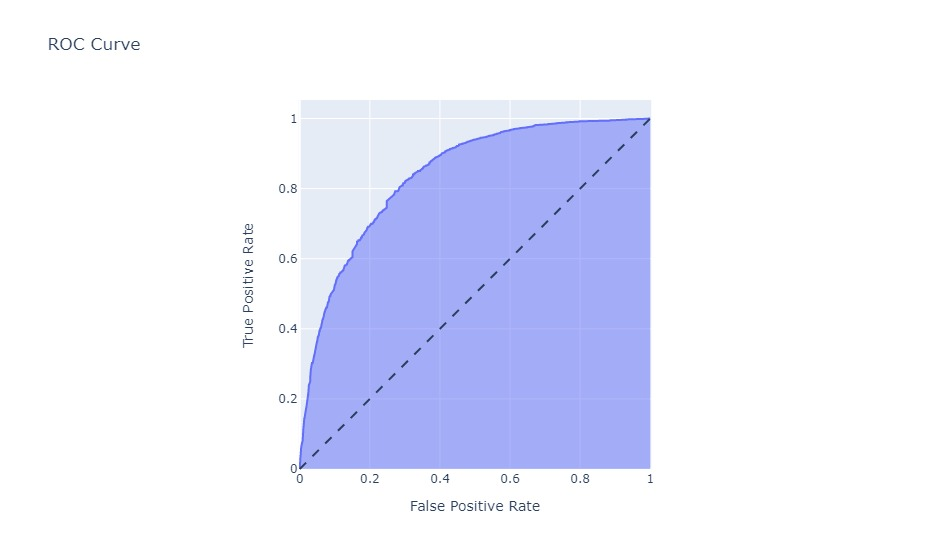

In [45]:
all_result = my_CV(LogisticRegression(random_state=RA_ST), X_train, y_train, all_result,\
                      {'classifier__penalty': ['l1'],\
                       'classifier__class_weight': [None],\
                       'classifier__solver': ['liblinear'],\
                       'classifier__max_iter': [50]})

,Модель,Оптимальные параметры,ROC-AUC кросс-валидация,accuracy кросс-валидация,"Время обучения, сек.",ROC-AUC тест,accuracy тест,precision тест,recall тест,"Время предсказания, сек."
0,RandomForestClassifier,"{'classifier__class_weight': {0: 1, 1: 2}, 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 500}",0.8512,0.8323,7.8,None,None,None,None,None


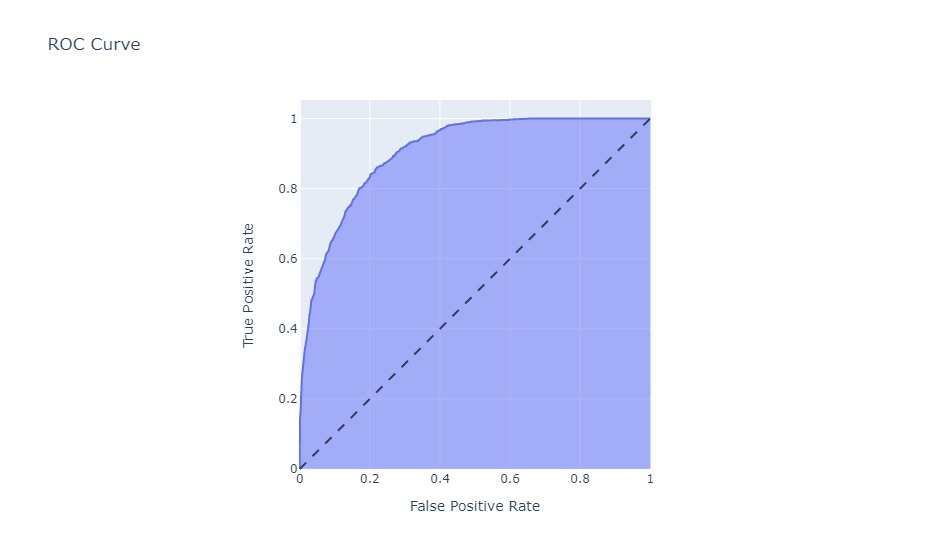

In [46]:
all_result = my_CV(RandomForestClassifier(random_state=RA_ST), X_train, y_train, all_result,\
                      {'classifier__n_estimators': [500],\
                       'classifier__criterion': ['entropy'],\
                       'classifier__max_depth': [10],\
                       'classifier__min_samples_split': [15],\
                       'classifier__class_weight': [{0:1, 1:2}]})

,Модель,Оптимальные параметры,ROC-AUC кросс-валидация,accuracy кросс-валидация,"Время обучения, сек.",ROC-AUC тест,accuracy тест,precision тест,recall тест,"Время предсказания, сек."
0,KNeighborsClassifier,"{'classifier__algorithm': 'auto', 'classifier__leaf_size': 40, 'classifier__n_neighbors': 43, 'classifier__p': 1, 'classifier__weights': 'uniform'}",0.8364,0.812,0.62,None,None,None,None,None


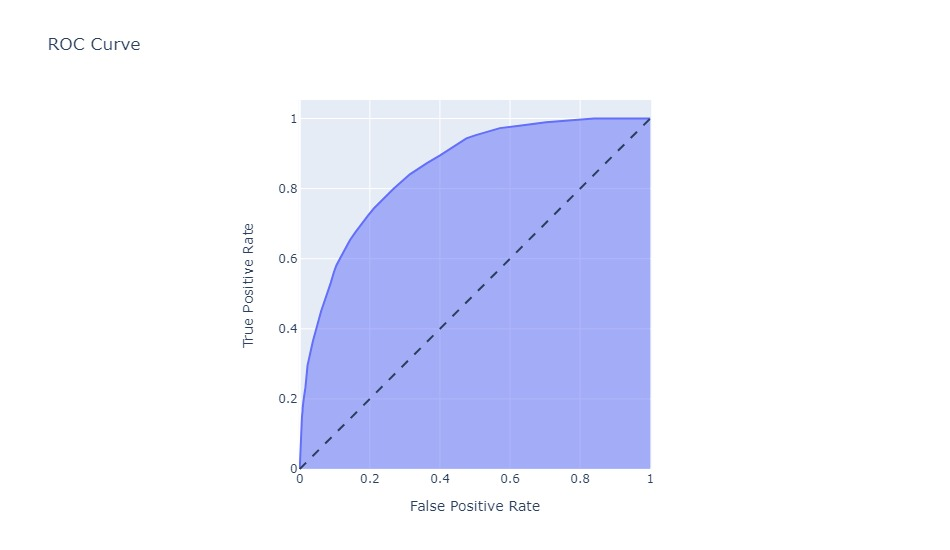

In [47]:
all_result = my_CV(KNeighborsClassifier(), X_train, y_train, all_result,\
                      {'classifier__n_neighbors': [43],\
                       'classifier__weights': ['uniform'],\
                       'classifier__algorithm': ['auto'],\
                       'classifier__leaf_size': [40],\
                       'classifier__p': [1]})

,Модель,Оптимальные параметры,ROC-AUC кросс-валидация,accuracy кросс-валидация,"Время обучения, сек.",ROC-AUC тест,accuracy тест,precision тест,recall тест,"Время предсказания, сек."
0,SVC,"{'classifier__C': 0.5, 'classifier__class_weight': {0: 1, 1: 2}, 'classifier__degree': 2, 'classifier__kernel': 'linear'}",0.8363,0.7705,7.96,None,None,None,None,None


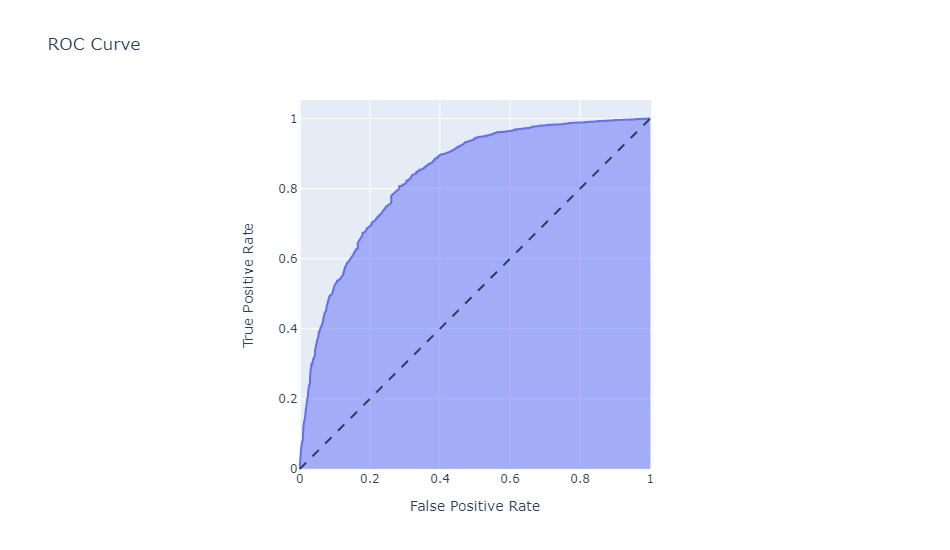

In [48]:
all_result = my_CV(SVC(random_state=RA_ST, probability=True), X_train, y_train, all_result,\
                      {'classifier__C': [0.5],\
                       'classifier__kernel': ['linear'],\
                       'classifier__class_weight': [{0:1, 1:2}],\
                       'classifier__degree': [2]})

,Модель,Оптимальные параметры,ROC-AUC кросс-валидация,accuracy кросс-валидация,"Время обучения, сек.",ROC-AUC тест,accuracy тест,precision тест,recall тест,"Время предсказания, сек."
0,<catboost.core.CatBoostClassifier object at 0x00000191C9F35040>,"{'classifier__class_weights': [1, 2], 'classifier__depth': 5, 'classifier__iterations': 3000, 'classifier__learning_rate': 0.025, 'classifier__loss_function': 'Logloss'}",0.9356,0.9214,31.96,None,None,None,None,None


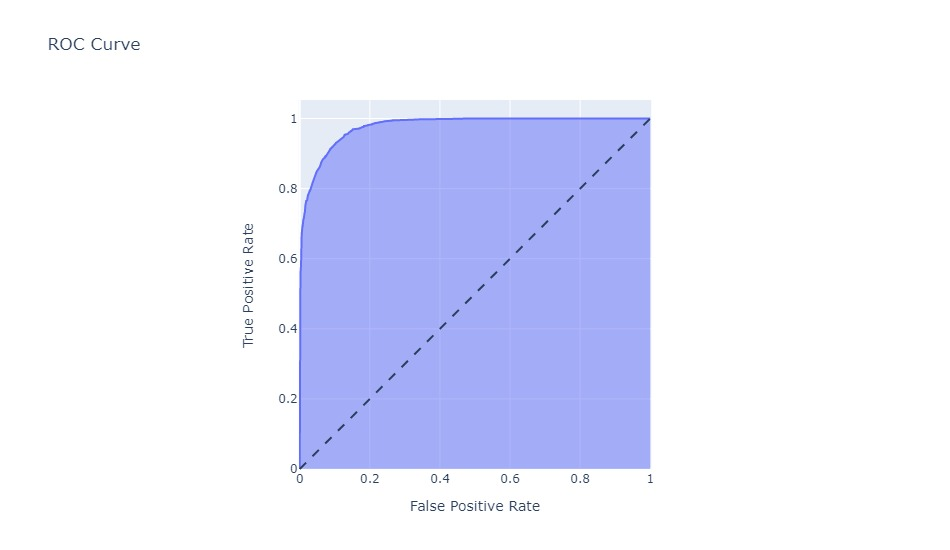

In [49]:
all_result = my_CV(CatBoostClassifier(random_state=RA_ST, verbose=0), X_train, y_train, all_result,\
                      {'classifier__iterations': [3000],\
                       'classifier__depth': [5],\
                       'classifier__learning_rate': [0.025],\
                       'classifier__loss_function': ['Logloss'],\
                       'classifier__class_weights': [[1, 2]]})

all_result.iloc[4,0] = 'CatBoostClassifier'

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


,Модель,Оптимальные параметры,ROC-AUC кросс-валидация,accuracy кросс-валидация,"Время обучения, сек.",ROC-AUC тест,accuracy тест,precision тест,recall тест,"Время предсказания, сек."
0,LGBMClassifier,"{'classifier__ scale_pos_weight': 1, 'classifier__feature_fraction': 0.7, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 2000, 'classifier__num_leaves': 55}",0.9118,0.9109,7.3,None,None,None,None,None


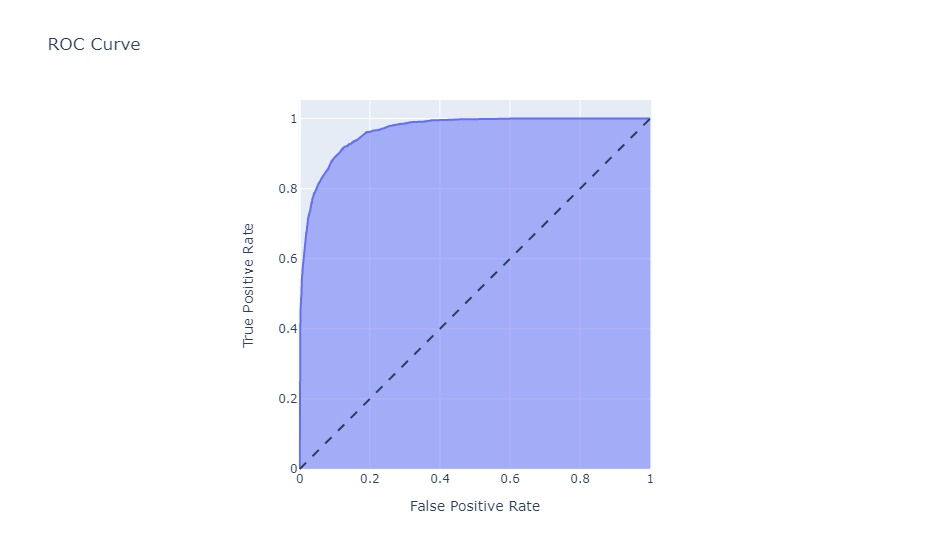

In [50]:
all_result = my_CV(LGBMClassifier(random_state=RA_ST), X_train, y_train, all_result,\
                      {'classifier__num_leaves': [55],\
                       'classifier__max_depth': [6],\
                       'classifier__learning_rate': [0.01],\
                       'classifier__n_estimators': [2000],\
                       'classifier__ scale_pos_weight': [1],\
                       'classifier__feature_fraction': [0.7]})

Изучим результаты обучения моделей

In [51]:
display(all_result)

,Модель,Оптимальные параметры,ROC-AUC кросс-валидация,accuracy кросс-валидация,"Время обучения, сек.",ROC-AUC тест,accuracy тест,precision тест,recall тест,"Время предсказания, сек."
0,LogisticRegression,"{'classifier__class_weight': None, 'classifier__max_iter': 50, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}",0.8377,0.7987,4.76,None,None,None,None,None
1,RandomForestClassifier,"{'classifier__class_weight': {0: 1, 1: 2}, 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 500}",0.8512,0.8323,7.80,None,None,None,None,None
2,KNeighborsClassifier,"{'classifier__algorithm': 'auto', 'classifier__leaf_size': 40, 'classifier__n_neighbors': 43, 'classifier__p': 1, 'classifier__weights': 'uniform'}",0.8364,0.8120,0.62,None,None,None,None,None
3,SVC,"{'classifier__C': 0.5, 'classifier__class_weight': {0: 1, 1: 2}, 'classifier__degree': 2, 'classifier__kernel': 'linear'}",0.8363,0.7705,7.96,None,None,None,None,None
4,CatBoostClassifier,"{'classifier__class_weights': [1, 2], 'classifier__depth': 5, 'classifier__iterations': 3000, 'classifier__learning_rate': 0.025, 'classifier__loss_function': 'Logloss'}",0.9356,0.9214,31.96,None,None,None,None,None
5,LGBMClassifier,"{'classifier__ scale_pos_weight': 1, 'classifier__feature_fraction': 0.7, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 2000, 'classifier__num_leaves': 55}",0.9118,0.9109,7.30,None,None,None,None,None


Простейшие модели, такие как Логическая регрессия, К-ближайших соседей и метод опорных векторов, удовлетворительно справились с задачей. По результатам кросс-валидации площадь под ROC-кривой у них не привысила 84%, а правильность предсказаний не более 81%. Не плохо на обучающей выборке отработал ансамбль деревьев с показателем площади под ROC-кривой в 85% и правильностью предсказаний 83%. Лучшими моделями по результатам кросс-валидации можно считать модели с использованием градиентного бустинга. Площадь под ROC-кривой у лидера CatBoost составил 93.5%, а правильность предсказания 92%. Перейдем к тестированию моделей.

## 6. Тестирование моделей
<a id="6"></a>

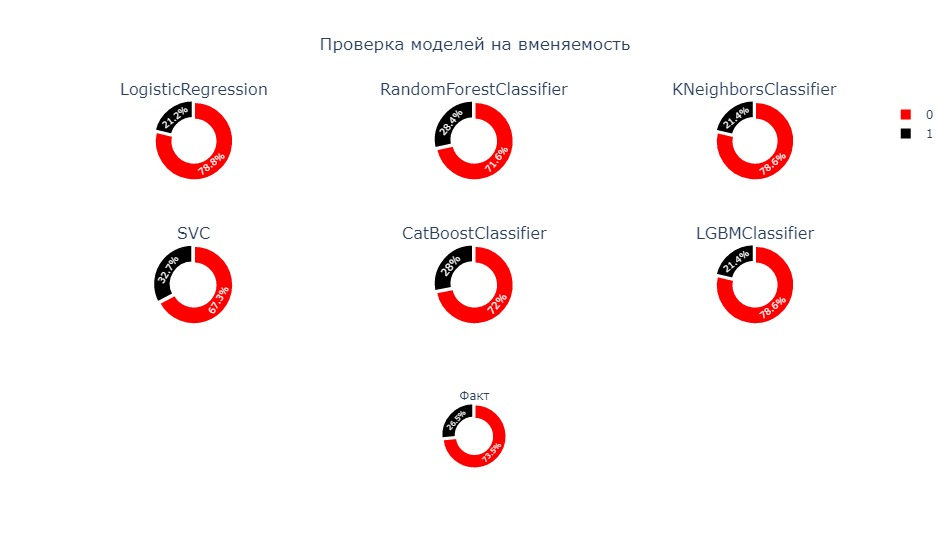

========================================...РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ...========================================


,Модель,Оптимальные параметры,ROC-AUC кросс-валидация,accuracy кросс-валидация,"Время обучения, сек.",ROC-AUC тест,accuracy тест,precision тест,recall тест,"Время предсказания, сек."
0,LogisticRegression,"{'classifier__class_weight': None, 'classifier__max_iter': 50, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}",0.8377,0.7987,4.76,0.8309,0.7921,0.6355,0.508,0.03
1,RandomForestClassifier,"{'classifier__class_weight': {0: 1, 1: 2}, 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_split': 15, 'classifier__n_estimators': 500}",0.8512,0.8323,7.80,0.8453,0.7913,0.6,0.6417,0.32
2,KNeighborsClassifier,"{'classifier__algorithm': 'auto', 'classifier__leaf_size': 40, 'classifier__n_neighbors': 43, 'classifier__p': 1, 'classifier__weights': 'uniform'}",0.8364,0.8120,0.62,0.8248,0.785,0.6179,0.4973,0.34
3,SVC,"{'classifier__C': 0.5, 'classifier__class_weight': {0: 1, 1: 2}, 'classifier__degree': 2, 'classifier__kernel': 'linear'}",0.8363,0.7705,7.96,0.8292,0.7736,0.5597,0.6898,0.14
4,CatBoostClassifier,"{'classifier__class_weights': [1, 2], 'classifier__depth': 5, 'classifier__iterations': 3000, 'classifier__learning_rate': 0.025, 'classifier__loss_function': 'Logloss'}",0.9356,0.9214,31.96,0.9481,0.8843,0.7671,0.8102,0.04
5,LGBMClassifier,"{'classifier__ scale_pos_weight': 1, 'classifier__feature_fraction': 0.7, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 2000, 'classifier__num_leaves': 55}",0.9118,0.9109,7.30,0.9201,0.8772,0.8339,0.6711,0.12


In [52]:
fig = make_subplots(rows=3, cols=3, subplot_titles=all_result['Модель'].values,\
                    specs=[[{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}],\
                           [{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}],\
                           [{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}]])

for i in range(len(best_models)):
    time_start_fit = timeit.default_timer()
    predict_proba_test = best_models[i].predict_proba(X_test)
    predict_test = best_models[i].predict(X_test)
    all_result.iloc[i,9] = round(timeit.default_timer() - time_start_fit, 2)
    all_result.iloc[i,5] = round(roc_auc_score(y_test, predict_proba_test[:,1]), 4)
    all_result.iloc[i,6] = round(accuracy_score(y_test, predict_test), 4)
    all_result.iloc[i,7] = round(precision_score(y_test, predict_test), 4)
    all_result.iloc[i,8] = round(recall_score(y_test, predict_test), 4)
    temp_data = pd.Series(predict_test).value_counts()
    row, col = 1, i+1
    if i > 2:
        row, col = 2, i-2
    fig.add_trace(go.Pie(values=temp_data.values, labels=temp_data.index), row=row, col=col)

fig.add_trace(go.Pie(values=[73.5, 26.5], labels=[0, 1], title='Факт',\
                     titleposition='top center'), row=3, col=2)

fig.update_traces(pull=[0.0, 0.05], hole=.55, textposition='inside', textinfo='percent',\
                  marker=dict(colors=['red', 'black'], line=dict(color='white', width=2)))
fig.update_layout(height=650, width=950, title_text='Проверка моделей на вменяемость', title_x = 0.5)

fig.show()
print('='*40 + '...РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ...' + '='*40)
display(all_result)

По результатам проверки на вменяемость, очень близкие к фактическим значения распределения долей целевого признака получились только у двух моделей - CatBoostClassifier и RandomForestClassifier. Модели LGBMClassifier, KNeighborsClassifier и LogisticRegression при определении класса имеют сдвиг в сторону отрицательного класса, а остальные модели наоборот, в сторону положительного.

По результатам тестирования лучшей моделью остается CatBoostClassifier. При этом показатель ROC-AUC у нее увеличился на 1.3%, в то время как правильность предсказания ухудшилась на 3.7% в сравнении с результатами на кросс-валидации. Кроме того доля правильно предсказанных клиентов на отключение среди всех предсказанных для положительного класса составила 77%, то есть модель в 23% случаев будет ошибаться, помечая клиента как склонного к уходу. А доля правильно предсказанных клиентов на отключение среди всех клиентов, которые вероятно уйдут, составляет 81%, что говорит о том что в 19% случаях модель не определит клиента, который вероятно отключится.

## 7. Отчет по выполненной работе
<a id="7"></a>

**Во время подготовки проекта были сделаны следующие шаги, выводы и предположения:**

- Первичный анализ и предобработка данных:
	- *В нашем распоряжении были 4 таблицы с данными - информация о договорах с 7043 клиентами, персональные данные клиента, информация об интернет услугах, информация об услугах телефонии;*
    - *Дубликаты во всех таблицах отсутствовали;*
    - *Наименования всех столбцов приведены к единому виду с разделением слов нижним подчеркиванием;*
    - *ID клиентов для каждой таблицы были переведены в статус индексов, а сами таблицы объединены в единую по индексам;*
    - *После объединения в новой таблице появились пропуски по услугами нтернета и телефонии потому, что часть клиентов не подключила себе одну из этих услуг. Пропуски заполнили значением "No";*
    - *Вывели два новых признака - факт подключения клиенту интернета и факт подключения клиенту телефонии;*
    - *Целевой признак, как таковой, отсутствовал. Но был признак с датой отключения клиента, где активные клиенты были помечены как "No", а по отключеным клиентам стояла дата отключения;*
    - *Клиенты отключались только в 4 определенные даты из всего периода выборки - первое число каждого месяца с октября 2019 по январь 2020 года включительно;*
    - *Вывели целевой признак в отдельный столбец как факт отключения со значениями "No" и "Yes".*
    
- Исследовательский анализ данных:
    - *Выгрузка содержит данные о клиентах с октября 2014 года по февраль 2020 включительно;*
    - *Обычно прирост клиентов не превышал отметку в 100 клиентов в месяц, но в феврале 2014-го он составил рекордные 366 человек, при том что за предыдущие первые 4 месяца по выборке было всего 15 новых клиентов. Далее прирост резко пошел на спад, но с января 2019 он плавно начал увеличиваться и в сентябре 2019 уже составлял 237 клиентов, держась примероно на этой отметке до конца периода выборки;*
    - *День выгрузки данных - 1 февраля 2020 года. Из этого месяца так же попали новые 11 клиентов, но у них образовались пропуски по общим платежам. Вероятно платежи не успели попасть в базу. Пропуски были заполнены значениями из ежемесячных платежей;*
    - *Были построены и изучены графики распределения активных и отключенных клиентов по категориальным признакам, а так же написан подробный вывод. Основные предположения по графикам:*
        - *Активные клиенты немногим чаще заключаеют договор на один месяц чем на два года или на один. Подавляющему большинству отключенных клиентов характерен срок заключения договора на 1 месяц;*
        - *Отключенные в разы чаще выбирают оплату по электронному чеку;*
        - *Среди отключенных клиентов в 1.8 раз чаще встречаются незамужние и холостые чем среди активных;*
        - *Вероятность ухода клиента гораздо выше, если он все же подключил себе интернет. Более того, чаще отключаются клиенты выбравшие оптоволоконное подключение;*
        - *Клиент не подключивший одну из дополнительных интернет-услуг имеет большую вероятность ухода;*
        - *Активные клиенты реже подключают услугу по стримминговому телевидению и доступу к каталогу фильмов.*
    - *Клиентов можно условно разделить на три основные группы по стоимости ежемесячного платежа:*
        - *Light - от 18 до 27.5 евро;*
        - *Standart - от 27.5 до 67.5 евро;*
        - *Advanced - от 67.5 до 119 евро.*
    - *Стоимость ежемесячного платежа можно разделить на 20 различных пакетов со средними значениями начиная с 20 евро с шагом в 5 евро и заканчивая 115 евро;*
    - *Отключенные клиенты чаще выбирают пакет Advanced, тогда как активные выбирают пакет Light. Пакет Standart наименее популярный для обоих групп. Средняя и медианная стоимость ежемесячного платежа у отключенных клиентов заметно выше;*
    - *Общая сумма платежей для активных и отключенных клиентов различна. Отключенные клиенты, хоть и чаще выбирают более дорогие пакеты услуг, в итоге в сумме платят меньше, что говорит о том что они ненадолго задерживаются в компании*
    - *Доля отключенных клиентов в выборке составляет 26.5%;*
    - *Выведен новый признак, обозначающий количество дней со дня заключения договора до момента выгрузки данных, или до даты расторжения договора для отключенных клиентов. По нему получено подтверждение, что отключенные клиенты в основном пользовались услугами компании короткое время;*
    - *Проведена проверка на мультиколлинеарность. Выявлена высокая корреляция между периодом пользования услугами и общей суммой платежей.*
- Подготовка к обучению моделей:
    - *Произведена анализ и проверка важности признаков. Неважные признаки были удалены из выборки. К важным признакам при определении склонности клиента к уходу относятся: срок заключения договора, факт выбора клиентом безналичного расчета, услуги по блокировка небезопасных сайтов и по предоставлению клиенту облачного хранилища, выделенная линия технической поддержки, стримминговое телевидение и доступ к катологу фильмов, возможность подключения телефонного аппарата к нескольким линиям одновременно, тип интернет-подключения и период активности клиента в днях;*
    - *Данные разделены на обучающе-валидационную выборку и на тестовую в соотношении 4 к 1;*
    - *Подготовлены функции для проведения кросс-валидации, масштабированию численных признаков, кодированию категориальных признаков, выводу графика ROC-кривой и результатов подбора оптимальных гиперпараметров и результатов обучения моделей;*
- Обучение моделей:
    - *Подобраны оптимальные гиперпараметры и обучены 6 моделей с различными алгоритмами классификации:*
        - *Логическая регрессия;*
        - *Случайный лес;*
        - *Метод k-ближайших соседей;*
        - *Метод опорных векторов;*
        - *Классификаторы CatBoost и LightGBM с использованием градиентного бустинга.*
    - *По результатам обучения лучшими моделями оказались CatBoost и LightGBM с значениями метрики ROC-AUC 0.936 и 0.912 соответственно.*
- Тестирование моделей:
    - *Проведена проверка на вменяемость для всех 6 моделей. Лучшие показатели у CatBoost и Случайного леса;*
    - *По результатам тестирования лучшей моделью остается CatBoostClassifier. Доля правильно предсказанных клиентов на отключение среди всех предсказанных для положительного класса составила 77%, то есть модель в 23% случаев будет ошибаться, помечая клиента как склонного к уходу. А доля правильно предсказанных клиентов на отключение среди всех клиентов, которые вероятно уйдут, составляет 81%, что говорит о том что в 19% случаях модель не определит клиента, который вероятно отключится. Доля правильных ответов в итоге составляет 88.4%.*